In [4]:
!pip install pandas
!pip install scikit-learn
!pip install pytorch_lightning
!pip install torchvision


[notice] A new release of pip available: 22.2.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [302]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
import random, os

from sklearn.manifold import TSNE

In [843]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv", index_col=[0])
df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


In [844]:
greek = pd.read_csv("../input/icr-identify-age-related-conditions/greeks.csv", index_col=[0])
greek

,Alpha,Beta,Gamma,Delta,Epsilon
Id,,,,,
000ff2bfdfe9,B,C,G,D,3/19/2019
007255e47698,A,C,M,B,Unknown
013f2bd269f5,A,C,M,B,Unknown
043ac50845d5,A,C,M,B,Unknown
044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...
fd3dafe738fd,A,B,M,B,9/13/2020
fd895603f071,A,B,M,B,9/8/2020
fd8ef6377f76,A,C,M,B,7/24/2019


In [845]:
# df = df.merge(greek, left_index = True, right_index=True)
# df['Class'] = df['Alpha']
# df = df.drop(['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon'], axis=1)
# df['Class'] = df['Class'].map({'A': 0, 'B': 1, 'D':2, 'G':3 }, na_action=None)

In [846]:
df['EJ'] = df['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)

In [847]:
col_mean = df.mean(axis=0)
for i, colname in enumerate(df.columns):
    df[colname].fillna(col_mean[i], inplace=True)
df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


In [848]:
scaler = RobustScaler().set_output(transform="pandas")
df.loc[:, df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

In [849]:
df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,-0.472222,-0.005214,0.000000,0.069272,0.000000,-1.880769,0.000000,-0.134115,1.123175,-0.463451,...,0.702705,0.598571,-0.347826,-0.642283,0.000000,-0.359338,-0.716263,0.641741,-0.010025,1
007255e47698,-0.680556,-0.989494,0.000000,0.611687,0.000000,-0.607692,0.000000,0.631510,0.000000,0.265382,...,-0.472232,-0.624571,0.666667,-0.819132,0.000000,1.240601,-0.124567,-0.197595,0.990161,0
013f2bd269f5,0.375000,-0.224190,0.000000,0.440180,0.000000,0.738462,0.000000,0.488281,0.000000,0.073301,...,0.770546,-0.153143,2.014493,1.581994,0.290982,0.359598,-0.218622,-0.129459,-0.006520,0
043ac50845d5,-0.333333,0.323123,1.226427,2.105694,0.000000,-0.584615,0.000000,0.122396,0.000000,-0.440533,...,0.508776,-0.624571,0.057971,-0.020900,0.178349,-0.353767,0.789556,1.101632,-0.008401,0
044fb8a146ec,0.083333,0.283109,0.000000,-0.239281,0.000000,-0.473077,2.594595,-1.459635,26.204380,0.388671,...,0.843681,46.670286,-0.289855,-0.204180,1.336815,0.042256,1.248820,-0.105640,-0.011111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,-0.666667,0.004501,1.351236,-0.410097,4.882164,-0.665385,4.594595,-0.395833,0.408759,-0.446912,...,-0.472232,0.128000,-0.405797,-0.847267,2.628881,0.015869,-0.504561,0.627426,0.990161,0
fd895603f071,0.263889,1.081978,0.000000,0.968303,7.834536,0.411538,0.027027,0.446615,0.661496,0.348963,...,1.185050,0.109714,0.362319,1.479904,7.718779,-0.292729,-0.081158,1.865560,-0.008881,0
fd8ef6377f76,0.236111,-0.305510,1.574611,1.295989,1.866864,1.319231,0.000000,1.022135,0.000000,0.473846,...,-0.472232,-0.624571,-0.405797,0.102894,1.023740,-0.083984,-0.375590,1.748697,0.990161,0


In [850]:
# df = df.fillna(0)
df.dtypes

AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ       float64
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

In [969]:
class cfg :
    TRAIN_BATCHSIZE = 32
    VALID_BATCHSIZE = 32
    learning_rate = 0.001
    num_epochs = 500

# dataset/dataloader

In [970]:
class MyDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index
    ) :
#         print(index, self.df.iloc[index])
        data = torch.Tensor(self.df.iloc[index, :-1].to_numpy())
        label = self.df.Class[index]
        
        return data, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.df)

# model

In [971]:
"""
margin: 通常、2クラス分類ではmarginの値は0.2から0.5の範囲で設定されます。
    この範囲内での値の選択は、同じクラスの特徴ベクトルを近くに、異なるクラスの
    特徴ベクトルを遠くに分離する効果を持ちます。具体的な値は実験によって調整する
    必要がありますが、一般的には0.3や0.4が試されることが多いです。
scale: 2クラス分類の場合、scaleの値は一般的に10から30程度が使用されます。
    値が大きいほど、クラス分類の確信度が高まりますが、適切な値はデータセットやタスクに
    依存します。一般的な出発点としては、10や20を試してみることができます。
"""


class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:
            one_hot = torch.zeros(cosine.size())
            one_hot.scatter_(1, label.view(-1, 1).long(), 1)
#             one_hot = torch.zeros(cosine.size(), device='cuda')
#             one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        else:
            output = cosine
        output *= self.s

        return output

In [1017]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, last_hidden_dim=32):
        super(MyModel, self).__init__()

        self.bn1 = nn.BatchNorm1d(input_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(last_hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, last_hidden_dim)
        self.arcface = ArcMarginProduct(last_hidden_dim, output_dim, s = 10, m = 0.3)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, labels):
#         x = self.bn1(x)
        x = F.mish(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        x = F.mish(self.bn3(self.fc2(x)))
#         x = self.dropout(x)
        if self.training:
            logits = self.arcface(x, self.training, labels)
        else:
            logits = self.arcface(x, self.training)
        return logits, x


In [1018]:
# dataset = MyDataset(df)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [1019]:
def balanced_log_loss(y_true, y_pred):
    y_pred = y_pred.astype('float64')
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

In [1020]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# criterion = F.cross_entropy


In [1021]:
balance = torch.Tensor([len(df)/sum(df.Class == i) for i in range(len(df.Class.unique()))])
balance /= sum(balance)
balance

tensor([0.1750, 0.8250])

In [1022]:
def train(fold, train_dataloader,valid_dataloader):
    best_score = 10**18
    input_dim = len(df.columns)-1
    output_dim = len(df.Class.unique())
    model = MyModel(input_dim, output_dim)

    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.CrossEntropyLoss(weight=balance)
    
    for epoch in range(cfg.num_epochs):
        y_true = []
        y_pred = []    

        model.train()  # モデルを訓練モードに設定
        total_loss = 0.0
        for batch in train_dataloader:
            inputs, labels = batch
            optimizer.zero_grad()  # 勾配の初期化
            # フォワード処理
            outputs, _ = model(inputs, labels)      
            # 損失の計算
            loss = criterion(outputs, labels)
            # バックワード処理
            loss.backward()
            # パラメータの更新
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_dataloader)

        model.eval()  # モデルをvalidモードに設定
        total_loss = 0.0


        for batch in valid_dataloader:
            inputs, labels = batch
            outputs, _ = model(inputs, labels)     
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            y_true += (labels.detach().tolist())
            y_pred += (1 - F.softmax(outputs, dim=1)[:, 0]).detach().tolist()
        avg_valid_loss = total_loss / len(valid_dataloader)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        score = balanced_log_loss(y_true, y_pred)

    #     if (epoch+1)%10 == 0 or best_score > score:
        if (epoch+1)%100 == 0:
            print(f"TRAIN : Epoch {epoch+1}/{cfg.num_epochs}, Average Loss: {avg_train_loss:.4f}",
                  f"VALID : Epoch {epoch+1}/{cfg.num_epochs}, Average Loss: {avg_valid_loss:.4f}, score = {score}")
#         if epoch > 100 and best_score > score and avg_valid_loss > avg_train_loss:
        if epoch > 100 and best_score > score:
            print(f"TRAIN : Epoch {epoch+1}/{cfg.num_epochs}, Average Loss: {avg_train_loss:.4f}",
                  f"VALID : Epoch {epoch+1}/{cfg.num_epochs}, Average Loss: {avg_valid_loss:.4f}, score = {score} Saved.")
            best_score = min(best_score, score)
            torch.save(model.state_dict(), f"model_weight_fold{fold}.pth")

    torch.save(model.state_dict(), f"model_weight_last_fold{fold}.pth")

    return best_score


In [1023]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num = 0
seed_everything(42)
score = 0
for train_idx, valid_idx in kf.split(df, df.Class):
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]
    train_dataset = MyDataset(train_df)
    valid_dataset = MyDataset(valid_df)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)
    
    print(f"Fold{num}")
    score += train(num, train_dataloader, valid_dataloader)
    
    num+=1

score/5

Fold0
TRAIN : Epoch 100/500, Average Loss: 0.5628 VALID : Epoch 100/500, Average Loss: 0.4397, score = 0.6045817184044056
TRAIN : Epoch 102/500, Average Loss: 0.5382 VALID : Epoch 102/500, Average Loss: 0.3112, score = 0.35173432705785534 Saved.
TRAIN : Epoch 105/500, Average Loss: 0.6087 VALID : Epoch 105/500, Average Loss: 0.2974, score = 0.288113070285564 Saved.
TRAIN : Epoch 107/500, Average Loss: 0.6501 VALID : Epoch 107/500, Average Loss: 0.2415, score = 0.24609724419067913 Saved.
TRAIN : Epoch 200/500, Average Loss: 0.3628 VALID : Epoch 200/500, Average Loss: 0.7531, score = 1.0406685943740428
TRAIN : Epoch 300/500, Average Loss: 0.3262 VALID : Epoch 300/500, Average Loss: 0.8846, score = 1.3171111853308899
TRAIN : Epoch 400/500, Average Loss: 0.2582 VALID : Epoch 400/500, Average Loss: 0.9221, score = 1.3116067349537743
TRAIN : Epoch 500/500, Average Loss: 0.2153 VALID : Epoch 500/500, Average Loss: 0.8331, score = 1.2187856673000832
Fold1
TRAIN : Epoch 100/500, Average Loss: 0

0.4912655086515724

In [1024]:
input_dim = len(df.columns)-1
output_dim = len(df.Class.unique())

models = []
for i in range(5):
    model = MyModel(input_dim, output_dim)
    model.load_state_dict(torch.load(f'model_weight_fold{i}.pth'))
    models.append(model)

In [1025]:
test_dataset = MyDataset(df)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

y = []
pred = []
l = []

for batch in test_dataloader:
    inputs, labels = batch
    for i in range(5):
        pp, xx = models[i](inputs, labels)
        pp = F.softmax(pp, dim=1)
        if i == 0:
            p = pp
            x = xx
        else:
            p += pp
            x += xx
    x /= 5
    p = F.softmax(p, dim=1)
    if len(y) == 0:
        y = x.detach().numpy()
        pred = p.detach().numpy()
        l = labels.detach().numpy()
    else:
        y = np.vstack([y, x.detach().numpy()])
        pred = np.vstack([pred, p.detach().numpy()])
        l = np.hstack([l, labels.detach().numpy()])


In [1026]:
len(l), len(y)

(617, 617)

In [1027]:
y

array([[ 0.46819812,  0.78478813,  0.39140087, ..., -0.04393144,
        -0.08606654,  0.17243373],
       [-0.0137289 ,  0.08240464,  0.00127262, ...,  0.38435176,
         0.13045204,  0.39696732],
       [ 0.09811467,  0.23763481,  0.28799897, ...,  0.20411511,
        -0.08558367,  0.08386756],
       ...,
       [ 0.30790144,  0.2585953 ,  0.42337823, ...,  0.23516174,
        -0.0042109 ,  0.22141683],
       [ 0.08621468,  0.22602406,  0.21618815, ...,  0.26339883,
        -0.04340415,  0.19766979],
       [ 0.1148145 ,  0.06103941, -0.08405943, ...,  0.4720481 ,
         0.49217743,  0.6338385 ]], dtype=float32)

In [1028]:
y_true = l
y_pred = np.argmax(pred, axis=1)

In [1029]:
balanced_log_loss(l, 1-pred[:, 0])

0.29405059236859216

In [1030]:
y_true[:44], y_pred[:44]

(array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]))

In [1031]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9027552674230146

In [1032]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.90569745, 0.88888889])

In [1033]:
tsne = TSNE(n_components=2, random_state=0)
X_reduced_tsne = tsne.fit_transform(y)
X_reduced_tsne

array([[ 12.802396 ,  23.41745  ],
       [ -2.2727544, -17.765463 ],
       [  0.8694799,  11.575435 ],
       ...,
       [  4.4362617,   7.6406527],
       [ -4.7723536,   1.65236  ],
       [  7.617101 , -22.980629 ]], dtype=float32)

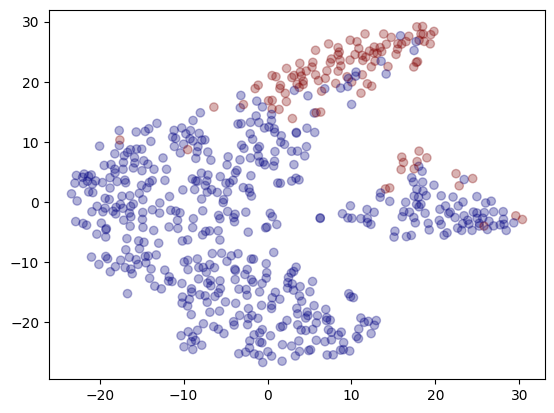

In [1034]:
# 可視化
import matplotlib.pyplot as plt
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_true, cmap='jet', alpha=0.3)
plt.show()

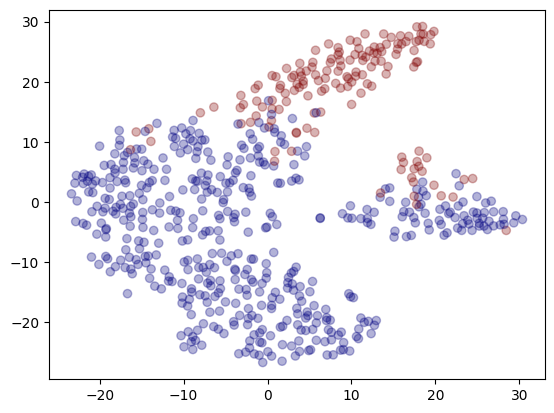

In [1035]:
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_pred, cmap='jet', alpha=0.3)
plt.show()